In [1]:
import tslearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn import metrics
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.piecewise import PiecewiseAggregateApproximation
import warnings
warnings.filterwarnings('ignore')

I used Weights&Biases on this notebook to monitor and track the performance of k-means 

In [2]:
import wandb
wandb.init(project="tscluster", entity="pillarxyz")

config = wandb.config
config.seed = 42
config.metric = 'dtw'
config.n_clusters = 4
config.run_dimrec = True
np.random.seed(config.seed)
wandb.config.update(config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


In [3]:
%env "WANDB_NOTEBOOK_NAME" "tscluster"

env: "WANDB_NOTEBOOK_NAME"="tscluster"


# Reading Data

In [4]:
stocks_df = pd.read_csv("data/stocks.csv")

In [5]:
companies = pd.read_csv("data/companies_isin.csv")
companies = companies[["Instrument", "Sector"]]

In [6]:
companies

,Instrument,Sector
0,AFMA,Insurance
1,Afric Indus,Construction & Building Materials
2,Afriquia Gaz,Oil & Gas
3,Agma,Insurance
4,Alliances,Real estate participation and promotion
...,...,...
71,Timar,Transport
72,Total Maroc,Oil & Gas
73,Unimer,Food producers & Processors
74,Wafa Assur,Insurance


In [7]:
companies.drop(companies[~companies["Instrument"].isin(stocks_df.columns)].index, inplace = True)
companies.reset_index(inplace = True, drop = True)

the dataset consists of closing prices of over 70 moroccan stocks including the MASI index

In [8]:
stocks_df

,date,Addoha,AFMA,Afric Indus,Afriquia Gaz,Agma,Alliances,Aluminium Maroc,Aradei Capital,ATLANTASANAD,...,SRM,Ste Boissons,STROC Indus,TAQA Morocco,Timar,Total Maroc,Unimer,Wafa Assur,Zellidja,MASI
0,01/02/2017,46.06,NaN,NaN,NaN,NaN,115.00,1300.0,NaN,47.15,...,283.45,NaN,53.10,800.0,243.0,1500.0,NaN,4850.0,NaN,12163.6391
1,02/02/2017,47.00,NaN,NaN,NaN,NaN,116.05,1300.0,NaN,48.10,...,279.25,NaN,50.50,794.0,228.5,1499.0,NaN,4910.0,NaN,12138.8644
2,03/02/2017,48.00,858.9,NaN,2600.0,NaN,116.00,1300.0,NaN,49.37,...,279.25,2300.0,50.00,803.9,214.8,1500.0,NaN,4899.0,NaN,12228.9917
3,06/02/2017,48.00,866.0,301.0,2600.0,2490.0,120.00,1300.0,NaN,49.18,...,283.70,2300.0,50.00,805.0,214.8,1500.0,NaN,4800.0,NaN,12247.6579
4,07/02/2017,49.00,850.0,300.0,2600.0,2342.0,128.00,1300.0,NaN,49.15,...,290.00,2300.0,52.84,805.0,214.8,1510.0,NaN,4800.0,NaN,12216.1686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,31/01/2022,11.65,1397.0,350.0,5615.0,4850.0,39.79,1432.0,451.0,134.00,...,151.10,3000.0,61.10,1200.0,144.0,1775.0,140.7,4850.0,93.00,13883.4936
1241,01/02/2022,11.62,1396.0,349.1,5895.0,4850.0,39.40,1432.0,453.0,132.50,...,151.10,3000.0,57.50,1200.0,144.7,1781.0,141.0,4850.0,96.71,13863.1054
1242,02/02/2022,11.60,1395.0,349.9,5900.0,4850.0,39.00,1432.0,447.0,135.00,...,153.00,3050.0,54.06,1205.0,149.8,1810.0,141.0,4850.0,100.50,13905.5098
1243,03/02/2022,11.51,1395.0,349.9,5724.0,4850.0,39.47,1433.0,450.0,141.80,...,155.00,3050.0,54.95,1220.0,154.8,1825.0,141.0,4850.0,96.49,13913.3935


### Formatting the date column

In [9]:
stocks_df.date = pd.to_datetime(stocks_df.date, format='%d/%m/%Y')

## Cleaning Data

In [10]:
(stocks_df.isnull().sum()*100 / stocks_df.shape[0]).sort_values(ascending = False).head(15)

Diac Salaf         100.000000
SAMIR              100.000000
Aradei Capital      76.947791
Mutandis            37.429719
Immr Invest         25.863454
Nexans Maroc         3.855422
Maghreb Oxygene      1.927711
Agma                 1.847390
Unimer               1.686747
Maghrebail           1.606426
Central.Danone       1.445783
Zellidja             1.365462
BALIMA               1.285141
Rebab Company        1.204819
Afric Indus          1.044177
dtype: float64

we remove columns having no data and then we fill the missing values with past or future values

In [11]:
stocks_df.drop(columns = ["SAMIR", "Diac Salaf", "Aradei Capital", "Mutandis", "Immr Invest"], inplace = True)

In [12]:
companies.drop(companies[companies["Instrument"].isin(["SAMIR", "Diac Salaf", "Aradei Capital", "Mutandis", "Immr Invest"])].index, inplace = True)
companies.reset_index(drop = True, inplace = True)

In [13]:
stocks_df = stocks_df.ffill()
stocks_df = stocks_df.bfill()

In [14]:
(stocks_df.isnull().sum()*100 / stocks_df.shape[0]).sort_values(ascending = False).head(15)

date               0.0
Med Paper          0.0
Res.Dar Saada      0.0
Rebab Company      0.0
PROMOPHARM         0.0
Oulmes             0.0
Nexans Maroc       0.0
Microdata          0.0
Maroc Telecom      0.0
S2M                0.0
Maroc Leasing      0.0
Managem            0.0
Maghrebail         0.0
Maghreb Oxygene    0.0
M2M Group          0.0
dtype: float64

In [15]:
stocks_df

,date,Addoha,AFMA,Afric Indus,Afriquia Gaz,Agma,Alliances,Aluminium Maroc,ATLANTASANAD,Attijariwafa,...,SRM,Ste Boissons,STROC Indus,TAQA Morocco,Timar,Total Maroc,Unimer,Wafa Assur,Zellidja,MASI
0,2017-02-01,46.06,858.9,301.0,2600.0,2490.0,115.00,1300.0,47.15,411.20,...,283.45,2300.0,53.10,800.0,243.0,1500.0,180.0,4850.0,140.00,12163.6391
1,2017-02-02,47.00,858.9,301.0,2600.0,2490.0,116.05,1300.0,48.10,420.00,...,279.25,2300.0,50.50,794.0,228.5,1499.0,180.0,4910.0,140.00,12138.8644
2,2017-02-03,48.00,858.9,301.0,2600.0,2490.0,116.00,1300.0,49.37,425.00,...,279.25,2300.0,50.00,803.9,214.8,1500.0,180.0,4899.0,140.00,12228.9917
3,2017-02-06,48.00,866.0,301.0,2600.0,2490.0,120.00,1300.0,49.18,428.95,...,283.70,2300.0,50.00,805.0,214.8,1500.0,180.0,4800.0,140.00,12247.6579
4,2017-02-07,49.00,850.0,300.0,2600.0,2342.0,128.00,1300.0,49.15,429.00,...,290.00,2300.0,52.84,805.0,214.8,1510.0,180.0,4800.0,140.00,12216.1686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,2022-01-31,11.65,1397.0,350.0,5615.0,4850.0,39.79,1432.0,134.00,493.05,...,151.10,3000.0,61.10,1200.0,144.0,1775.0,140.7,4850.0,93.00,13883.4936
1241,2022-02-01,11.62,1396.0,349.1,5895.0,4850.0,39.40,1432.0,132.50,494.10,...,151.10,3000.0,57.50,1200.0,144.7,1781.0,141.0,4850.0,96.71,13863.1054
1242,2022-02-02,11.60,1395.0,349.9,5900.0,4850.0,39.00,1432.0,135.00,495.30,...,153.00,3050.0,54.06,1205.0,149.8,1810.0,141.0,4850.0,100.50,13905.5098
1243,2022-02-03,11.51,1395.0,349.9,5724.0,4850.0,39.47,1433.0,141.80,498.00,...,155.00,3050.0,54.95,1220.0,154.8,1825.0,141.0,4850.0,96.49,13913.3935


we resample our time series from daily to weekly data

In [16]:
stocks_df = stocks_df.resample('7D', on = 'date').first().reset_index(drop = True)

In [17]:
stocks_df.index = stocks_df.date

In [18]:
stocks_df.drop("date", axis = 1, inplace = True)

In [19]:
stocks_df

,Addoha,AFMA,Afric Indus,Afriquia Gaz,Agma,Alliances,Aluminium Maroc,ATLANTASANAD,Attijariwafa,Auto Hall,...,SRM,Ste Boissons,STROC Indus,TAQA Morocco,Timar,Total Maroc,Unimer,Wafa Assur,Zellidja,MASI
date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,46.06,858.9,301.0,2600.0,2490.0,115.00,1300.0,47.15,411.20,114.90,...,283.45,2300.0,53.10,800.0,243.00,1500.0,180.0,4850.0,140.00,12163.6391
2017-02-08,49.95,850.0,300.0,2600.0,2342.0,133.20,1230.0,49.28,430.05,115.50,...,290.00,2300.0,52.70,809.0,227.65,1522.0,180.0,4927.0,140.00,12297.3179
2017-02-15,51.15,864.8,296.2,2755.0,2475.0,165.15,1230.0,48.50,430.00,114.80,...,336.75,2350.0,50.00,796.0,225.75,1502.0,180.0,4950.0,149.45,12279.5277
2017-02-22,49.70,900.0,296.0,2700.0,2489.0,179.00,1230.0,53.00,414.00,110.00,...,364.00,2350.0,49.05,790.0,211.00,1460.0,170.0,4740.0,149.00,11954.0850
2017-03-01,48.50,842.5,298.0,2750.0,2403.0,171.00,1300.0,52.90,420.15,109.00,...,361.00,2350.0,49.90,780.0,200.00,1434.0,170.0,4745.0,123.80,11876.7112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-05,10.70,1360.0,343.0,5205.0,4730.0,38.10,1392.0,119.30,482.10,105.50,...,146.00,2859.0,41.48,1100.0,137.90,1731.0,141.4,4756.0,74.00,13290.6250
2022-01-12,11.40,1350.0,345.0,5404.0,4550.0,39.00,1428.0,136.50,491.00,112.00,...,147.00,2859.0,43.20,1104.0,141.00,1750.0,142.0,4707.0,76.95,13531.2560
2022-01-19,11.87,1375.0,350.0,5500.0,4820.0,41.20,1424.0,134.20,492.20,112.30,...,150.00,3119.0,46.62,1245.0,141.00,1810.0,142.0,4845.0,80.02,13737.7096


In [20]:
stocks = stocks_df

# Visualization

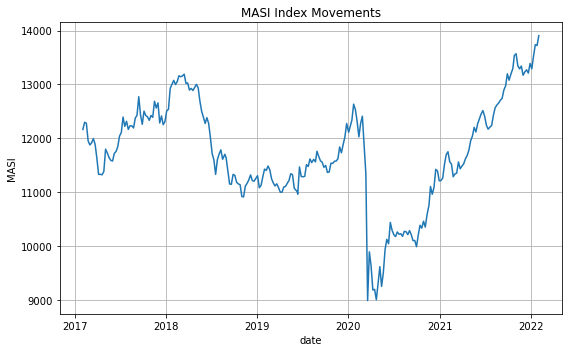

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(stocks_df.index, stocks_df["MASI"])
ax.grid()
ax.set_title('MASI Index Movements')
ax.set_ylabel('MASI')
ax.set_xlabel('date')
fig.tight_layout();

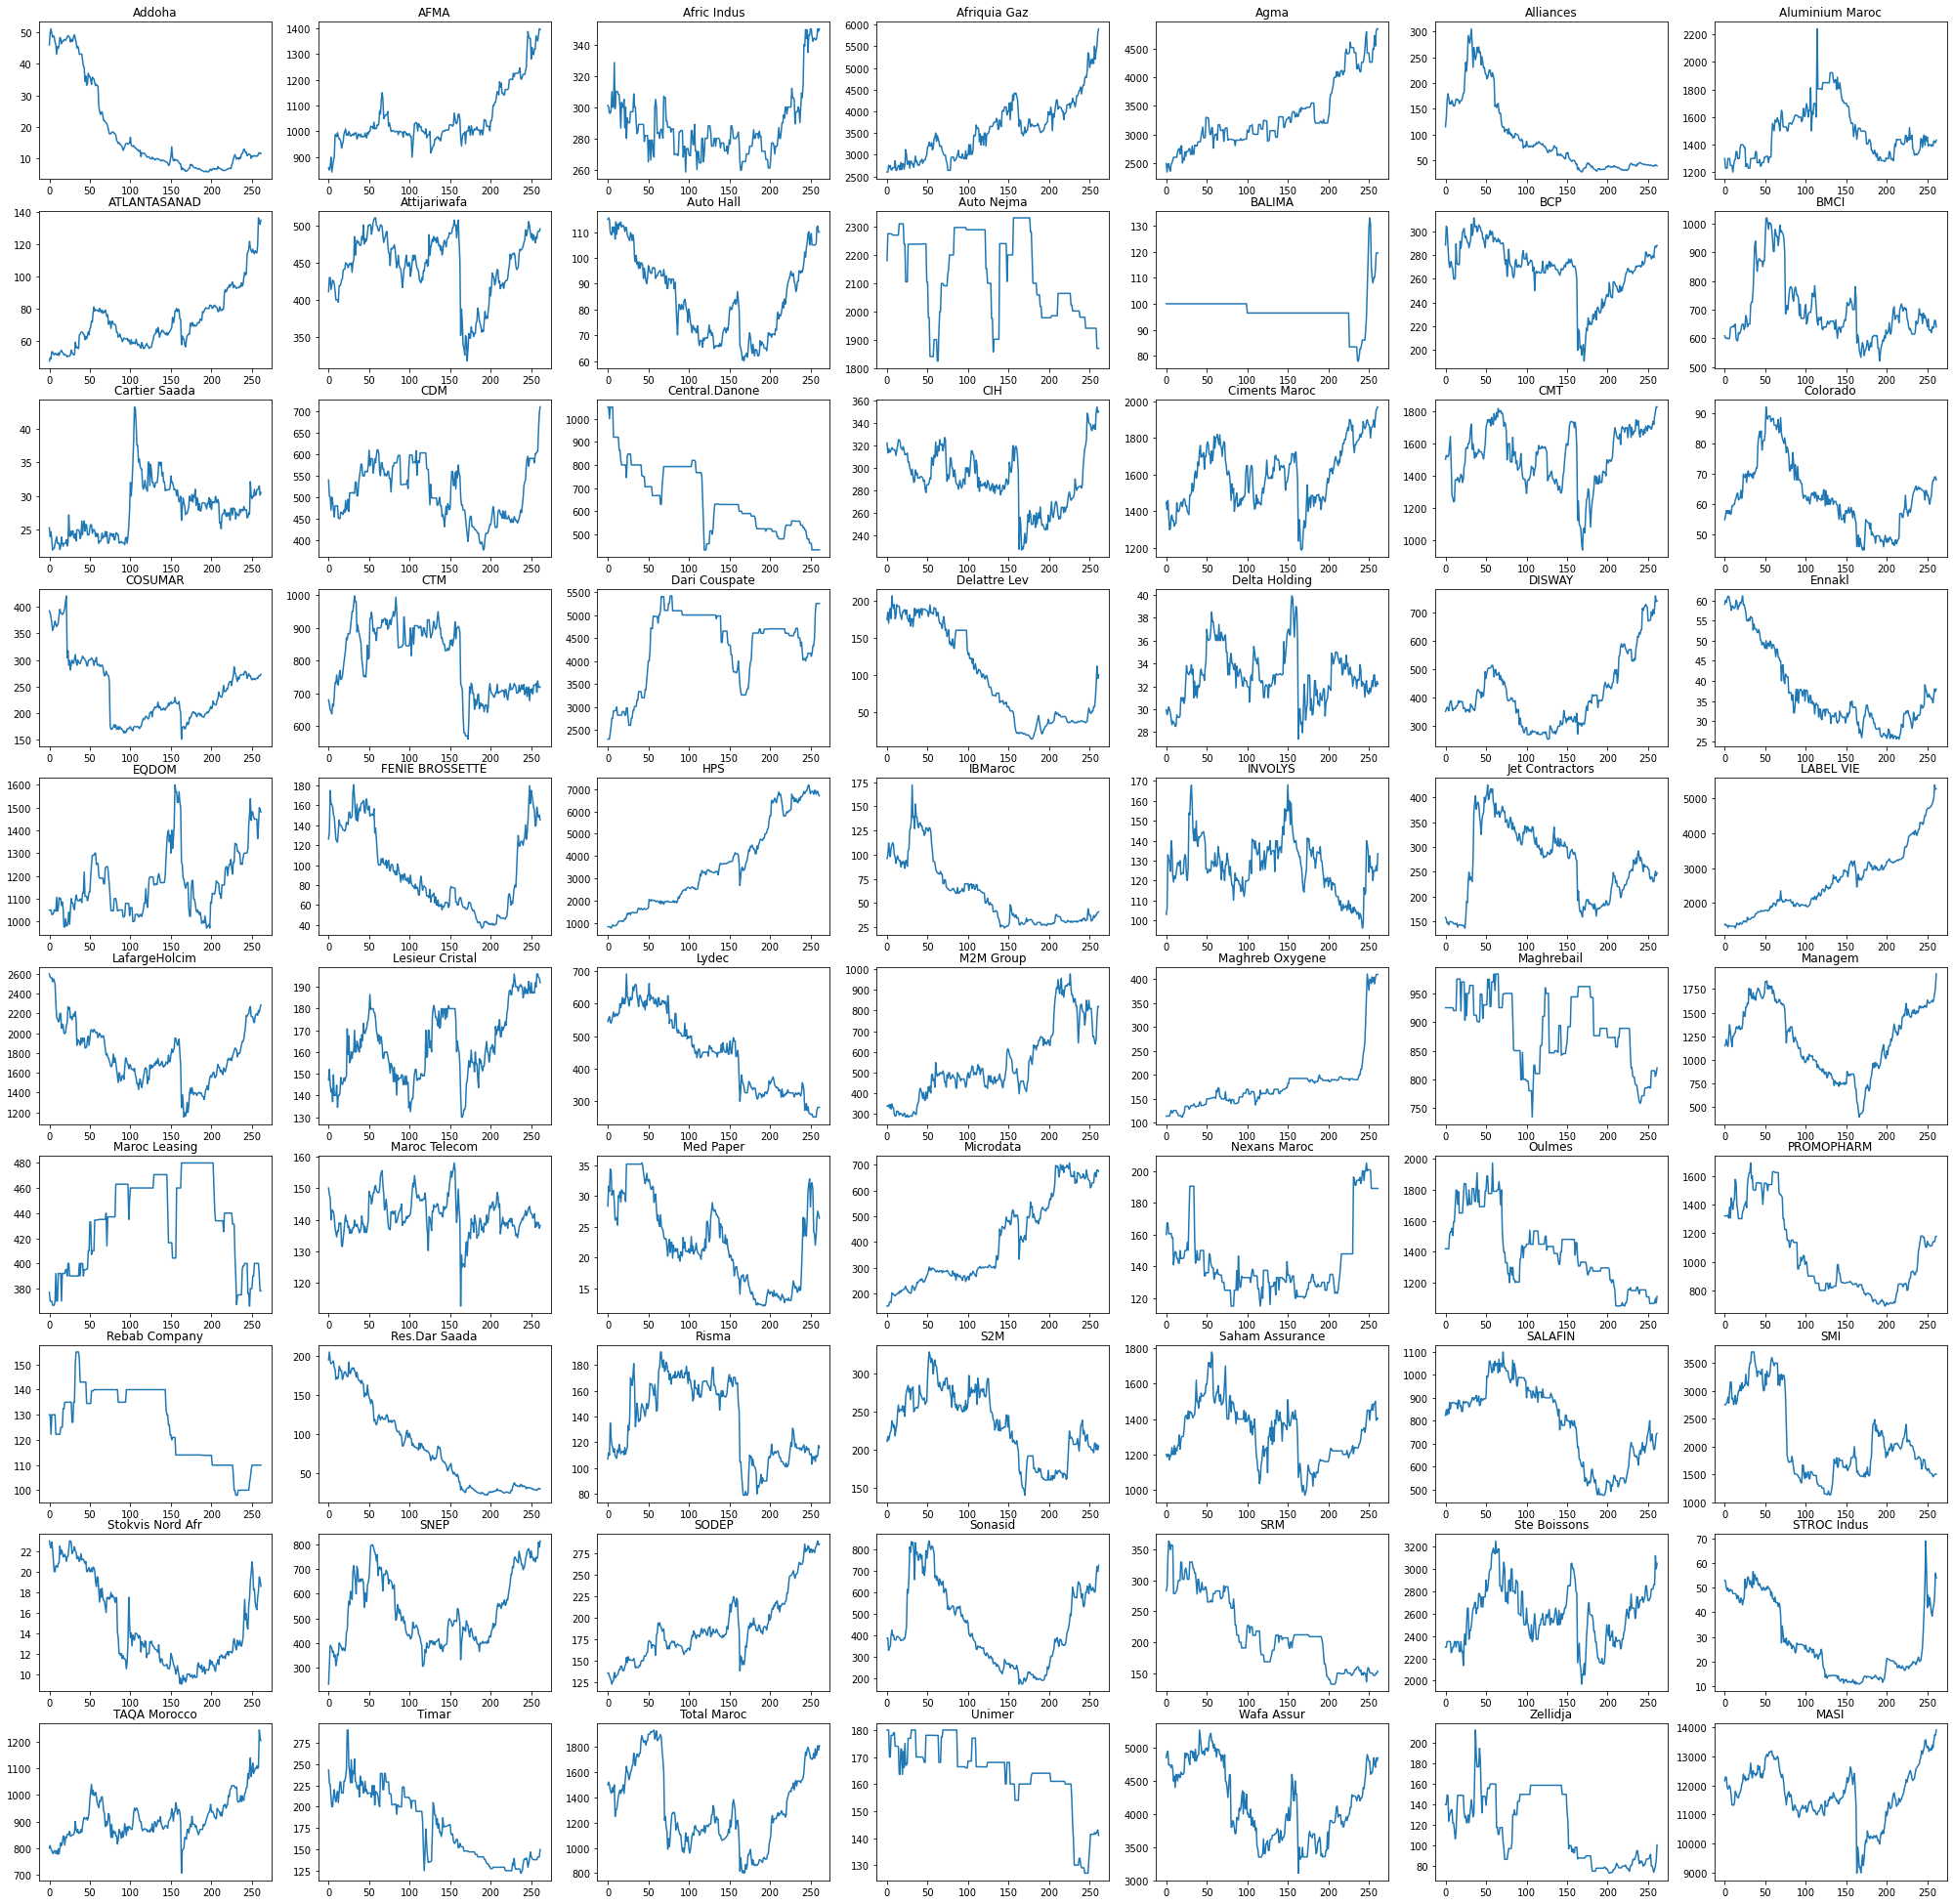

In [22]:
cols = stocks_df.columns

fig, axs = plt.subplots(10,7,figsize=(35,35))
for i in range(10):
    for j in range(7):
        axs[i, j].plot(stocks_df[cols[i*7+j]].values)
        axs[i, j].set_title(cols[i*7+j])
plt.show()

# Dimensionality Reduction

we can use PAA (Piecewise Aggregate Approximation) for dimensionality reduction

In [23]:
ts = np.array(stocks.T).reshape(stocks.T.shape[0], stocks.T.shape[1], 1)
ts = TimeSeriesScalerMinMax().fit_transform(ts)

In [24]:
if config.run_dimrec:
    n_segments = 10
    paa = PiecewiseAggregateApproximation(n_segments = n_segments)
    ts = paa.fit_transform(ts)
    wandb.log({"paa_segments" : n_segments})
    
cols = stocks.columns

# Clustering

In [25]:
km = TimeSeriesKMeans(n_clusters = config.n_clusters, random_state = config.seed, metric = config.metric)
y_pred = km.fit_predict(ts)
s = silhouette_score(ts, y_pred, metric=config.metric)
print("K-means metrics : ")
print(f"Silhouette score = {s}, \nInertia = {km.inertia_}")

K-means metrics : 
Silhouette score = 0.324131750067067, 
Inertia = 0.10928430900068625


In [26]:
wandb.run.summary["n_clusters"] = km.n_clusters
wandb.run.summary["silhouette_score"] = s
wandb.run.summary["Inertia"] = km.inertia_

In [27]:
wandb.log({"n_clusters" : km.n_clusters})
wandb.log({"silhouette_score" : s})
wandb.log({"Inertia" : km.inertia_})

In [28]:
wandb.config.update({'labels' : km.cluster_centers_})

In [29]:
companies = companies.rename({'Instrument': 'Company',}, axis=1) 

In [30]:
clusters_df = pd.DataFrame({'Company':stocks.columns, 'Cluster': y_pred}).sort_values(by = 'Cluster')
clusters_df.reset_index(drop = True, inplace = True)

In [31]:
clusters_df

,Company,Cluster
0,Colorado,0
1,Jet Contractors,0
2,INVOLYS,0
3,Delta Holding,0
4,Risma,0
...,...,...
65,Nexans Maroc,3
66,LafargeHolcim,3
67,Maroc Telecom,3
68,BCP,3


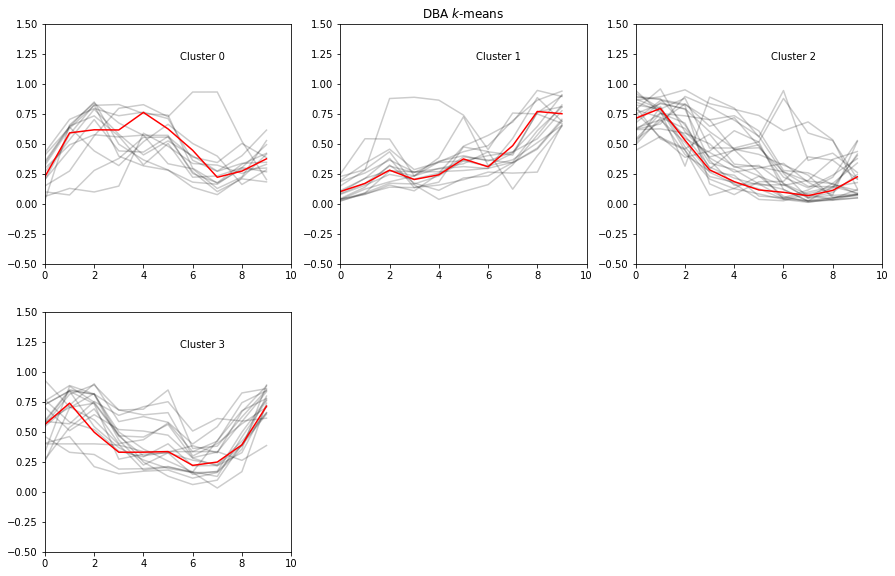

In [32]:
for yi in range(config.n_clusters):
    plt.subplot(3, 3, 4 + yi)
    for xx in ts[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, ts.shape[1])
    plt.ylim(-.5, 1.5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    plt.gcf().set_size_inches(15, 15)
    if yi == 1:
        plt.title("DBA $k$-means")

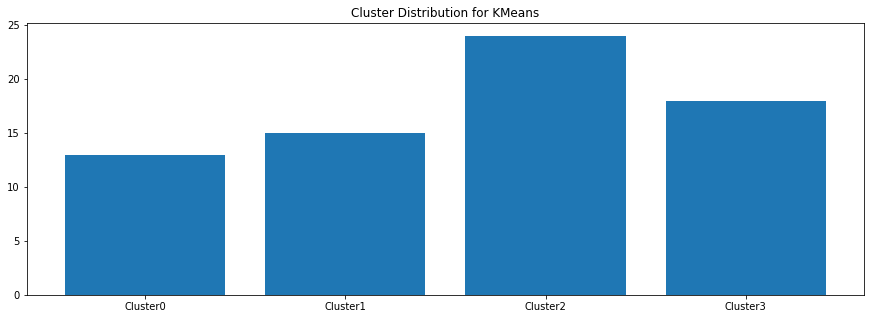

In [33]:
cluster_c = clusters_df["Cluster"].value_counts().sort_index()
cluster_n = [f"Cluster{str(i)}" for i in range(km.n_clusters)]
fig, ax = plt.subplots(1, 1,figsize=(15,5))
ax.set_title("Cluster Distribution for KMeans")
ax.bar(cluster_n, cluster_c)
plt.show()
wandb.log({"time series clustered": fig})

In [35]:
cluster_df = pd.merge(left=companies, right=clusters_df, left_on='Company', right_on='Company')
cluster_df.set_index('Company').to_csv("data/clustering-data.csv")

In [36]:
cluster_df

,Company,Sector,Cluster
0,AFMA,Insurance,1
1,Afric Indus,Construction & Building Materials,3
2,Afriquia Gaz,Oil & Gas,1
3,Agma,Insurance,1
4,Alliances,Real estate participation and promotion,2
...,...,...,...
58,Timar,Transport,2
59,Total Maroc,Oil & Gas,3
60,Unimer,Food producers & Processors,2
61,Wafa Assur,Insurance,3


In [ ]:
colors = ['blue', 'green','red', 'black', 'orange', 'brown', 'y']

fig, ax = plt.subplots(10, 7,figsize=(35,35))
for i in range(10):
    for j in range(7):
        try:
            ax[i, j].plot(stocks[cols[i*7+j]].values, color = colors[y_pred[i*7+j]])
            ax[i, j].set_title(f"{cols[i*7+j]}, Cluster {y_pred[i*7+j]}")
        except:
            fig.delaxes(ax[i, j])
            continue

plt.show()

# Conclusion

as we can see from the chart our algorithm did pretty well seperating stocks according to these patterns:
* Trending downward
* Trending upward
* Recovering from the pandemic
* Peaked during the pandemic

In [ ]:
wandb.finish()